## This notebook focuses on the analysis of the premiums_rest (age <= 25) dataset.

## Introduction

This document focuses on analyzing and predicting healthcare insurance premiums for individuals aged 25 and below, a segment that exhibited the highest percentage of extreme prediction errors in the initial modeling phase. To address this challenge, the dataset was deliberately segmented to allow more targeted analysis and model optimization for the younger population. The primary objective is to understand the key factors influencing premium variability within this age group and to improve predictive accuracy through tailored preprocessing and modeling strategies.

The workflow includes comprehensive data cleaning, handling of missing and inconsistent values, treatment of outliers, and encoding of categorical variables. Exploratory Data Analysis (EDA) is conducted to examine distributions, correlations, and behavioral patterns unique to younger policyholders. Feature engineering techniques, such as normalization of medical risk indicators and income-related variables, are applied to enhance model performance. Several regression-based and tree-based machine learning models are trained and evaluated to identify the most effective approach for predicting premiums in this demographic.

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [2]:
# Loading the data
df= pd.read_excel('premiums_young.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [3]:
# Number of rows and columns in the data
df.shape

(20096, 13)

In [4]:
# converting  all columns into consistent naming
df.columns = df.columns.str.replace(' ', '_' ).str.lower()
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [5]:
# Finding null values
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [6]:
# Dropping the null values
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [7]:
# Finding duplicate values
df.duplicated().sum()

0

In [8]:
# Getting more information about the dataset
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [9]:
# Getting info about number of dependants which are negative values
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-3, -1])

In [10]:
# Number of rows where number of dependants is less than zero
df[df.number_of_dependants<0].shape

(22, 13)

In [11]:
# Changing negative values of dependants positive
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [12]:
# Getting more information about number of dependants
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

After removing the negative values, it is clear that number of dependants varies from 0 to 3

In [13]:
# finding the numerical columns
numeric_columns = df.select_dtypes(['float64', 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

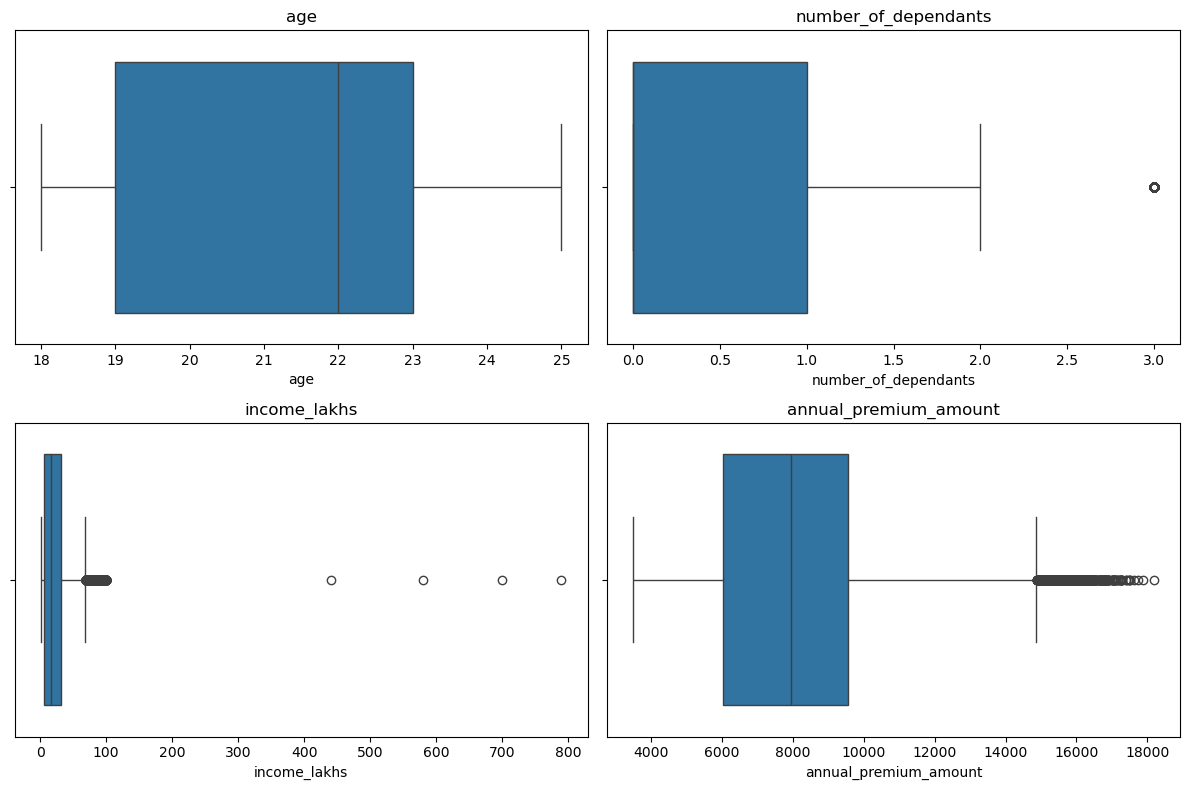

In [14]:
# Plotting the numerical column to check for outliers
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes = axes.flatten()   # flatten so we can index easily

for ax, col in zip(axes, numeric_columns[:4]):   # take first 4 columns
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()

In [15]:
# Finding the rows where age is greater than 100
df[df.age>100]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount


In [16]:
# finding uniques values of age over 100
df[df.age>100]['age'].unique()

array([], dtype=int64)

In [17]:
# Generating the dataset having age less or equal to 100
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

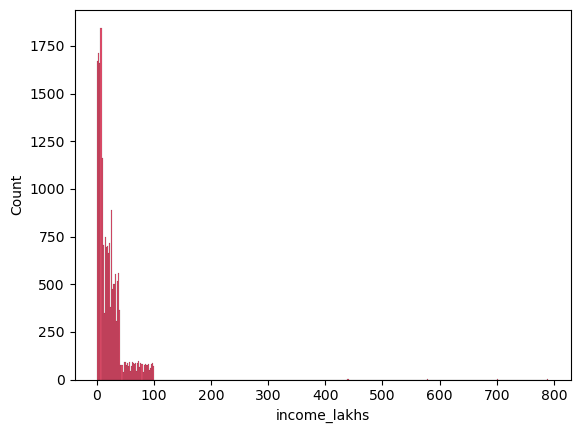

In [18]:
sns.histplot(df1.income_lakhs, color = 'crimson')

The histogram shows that most incomes cluster below ~50 lakhs, with counts dropping sharply as income increases. A few extreme outliers extend up to ~800 lakhs, creating a long right-skewed tail.

In [19]:
# Getting the quartile values for income
df1.income_lakhs.quantile([0.25, 0.75])

0.25     6.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [20]:
# getting upper bound and lower bound of income values

def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 +1.5 * IQR
    return lower_bound, upper_bound

In [21]:
# Setting the income threshold
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

100.0

In [22]:
# Finding the rows where income is greater than threshold value
df1[df1.income_lakhs > quantile_threshold].shape

(4, 13)

In [23]:
# getting the dataset where income is less than the income threshold value
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.shape

(20086, 13)

In [24]:
# Getting information about the new dataset
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263
std,2.294248,0.937238,21.732062,2749.912486
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,100.000000,18186.000000


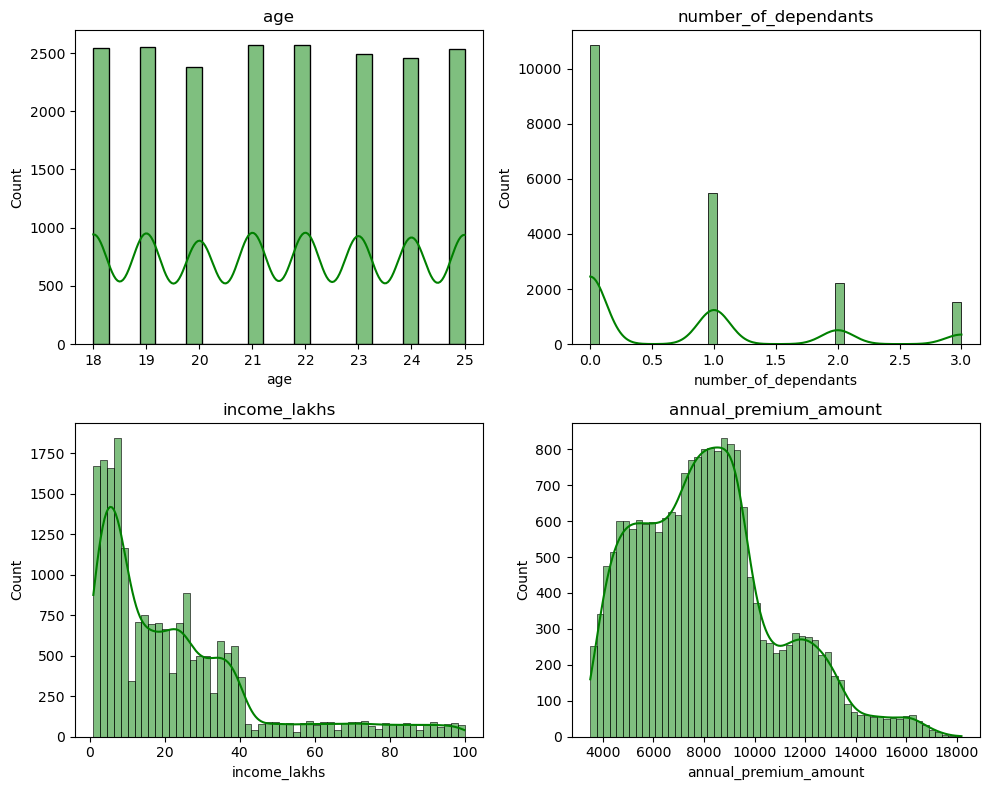

In [25]:
# Assume numeric_columns has 4 columns
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes = axes.flatten()

for ax, col in zip(axes, numeric_columns):
    sns.histplot(df2[col], kde=True, ax=ax, color='green')
    ax.set_title(col)

plt.tight_layout()
plt.show()

Age is uniformly distributed between 18–25, indicating an evenly sampled young population.

Number of dependents is heavily skewed toward 0–1, with very few having 2 or 3 dependents.

Income (lakhs) is right-skewed, with most people earning under 20 lakhs and a long tail of higher incomes.

Annual premium amountclusters around 7k–10k, with smaller secondary peaks at higher premium values.


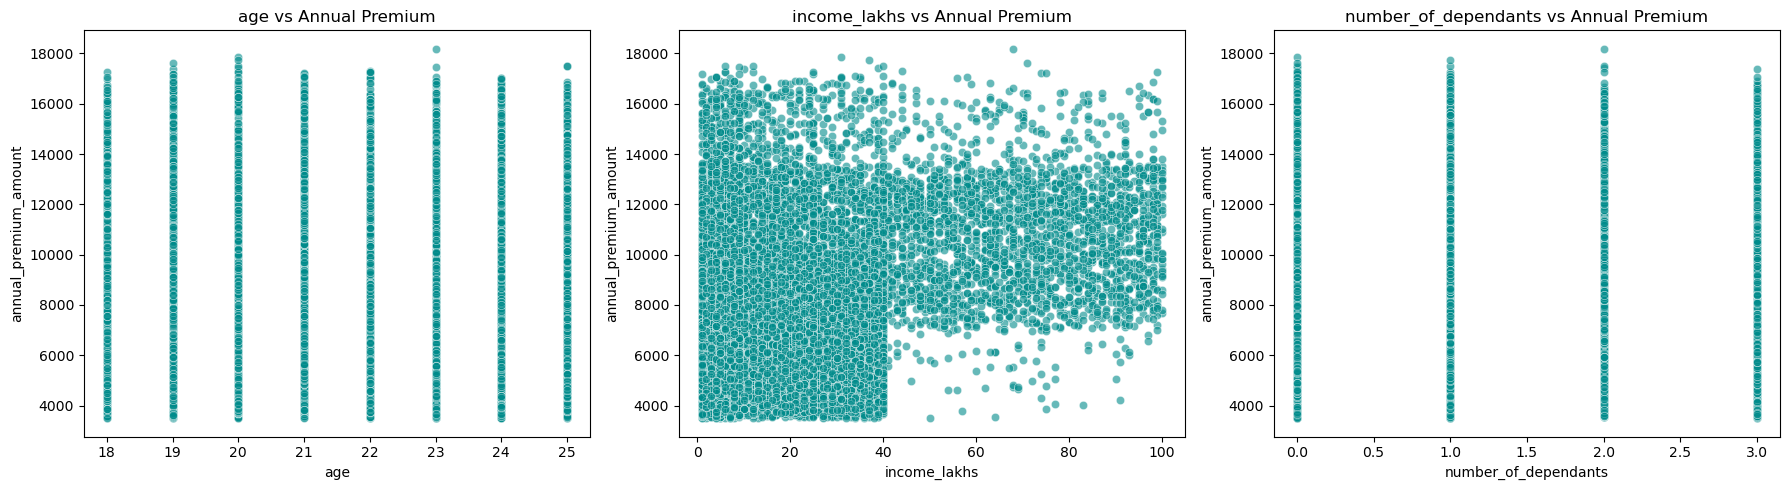

In [26]:
# Getting the scatter plot for age, income_lakhs, number of dependants vs annual premium amount
import matplotlib.pyplot as plt
import seaborn as sns

features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col in zip(axes, features):
    sns.scatterplot(data=df2, x=col, y='annual_premium_amount', alpha=0.6, ax=ax, color='darkcyan')
    ax.set_title(f'{col} vs Annual Premium')

plt.tight_layout()
plt.show()


Age and number of dependents show no visible correlation with annual premium — points form vertical stripes due to limited unique values.

Income has wide variation but still shows no strong linear relationship with annual premium.

Overall, annual premium appears largely independent of these three variables in the plotted data.


In [27]:
# getting the subcategories in the different category columns
categorical_cols = df2.select_dtypes(['object']).columns
for col in categorical_cols:
    print(col, df2[col].unique())

gender ['Male' 'Female']
region ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status ['Unmarried' 'Married']
bmi_category ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status ['Self-Employed' 'Freelancer' 'Salaried']
income_level ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan ['Silver' 'Bronze' 'Gold']


In [28]:
# Changing the different non-smoking categories to No Smoking 
df2['smoking_status'] = df2['smoking_status'].replace(
    {
        'Smoking=0': 'No Smoking',
        'Does Not Smoke': 'No Smoking',
        'Not Smoking': 'No Smoking'
    }
)
df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [29]:
# getting the gender count
df2['gender'].value_counts()

gender
Male      11055
Female     9031
Name: count, dtype: int64

In [30]:
# percentage count of the gender values
pct_count = df2['gender'].value_counts(normalize=True)
pct_count

gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64

In [31]:
pct_count.values

array([0.55038335, 0.44961665])

<Axes: xlabel='gender'>

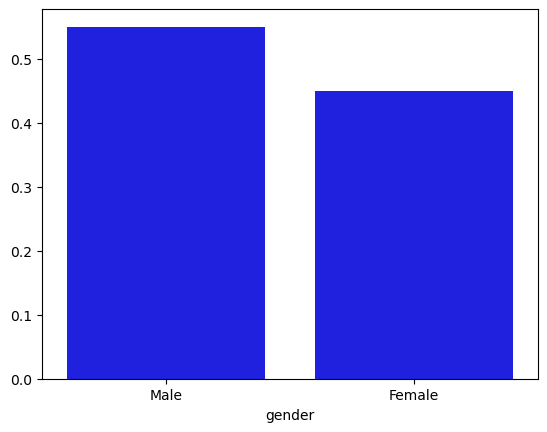

In [32]:
# Bar plot of the gender percentage count
sns.barplot(x=pct_count.index, y=pct_count.values, color = 'blue')

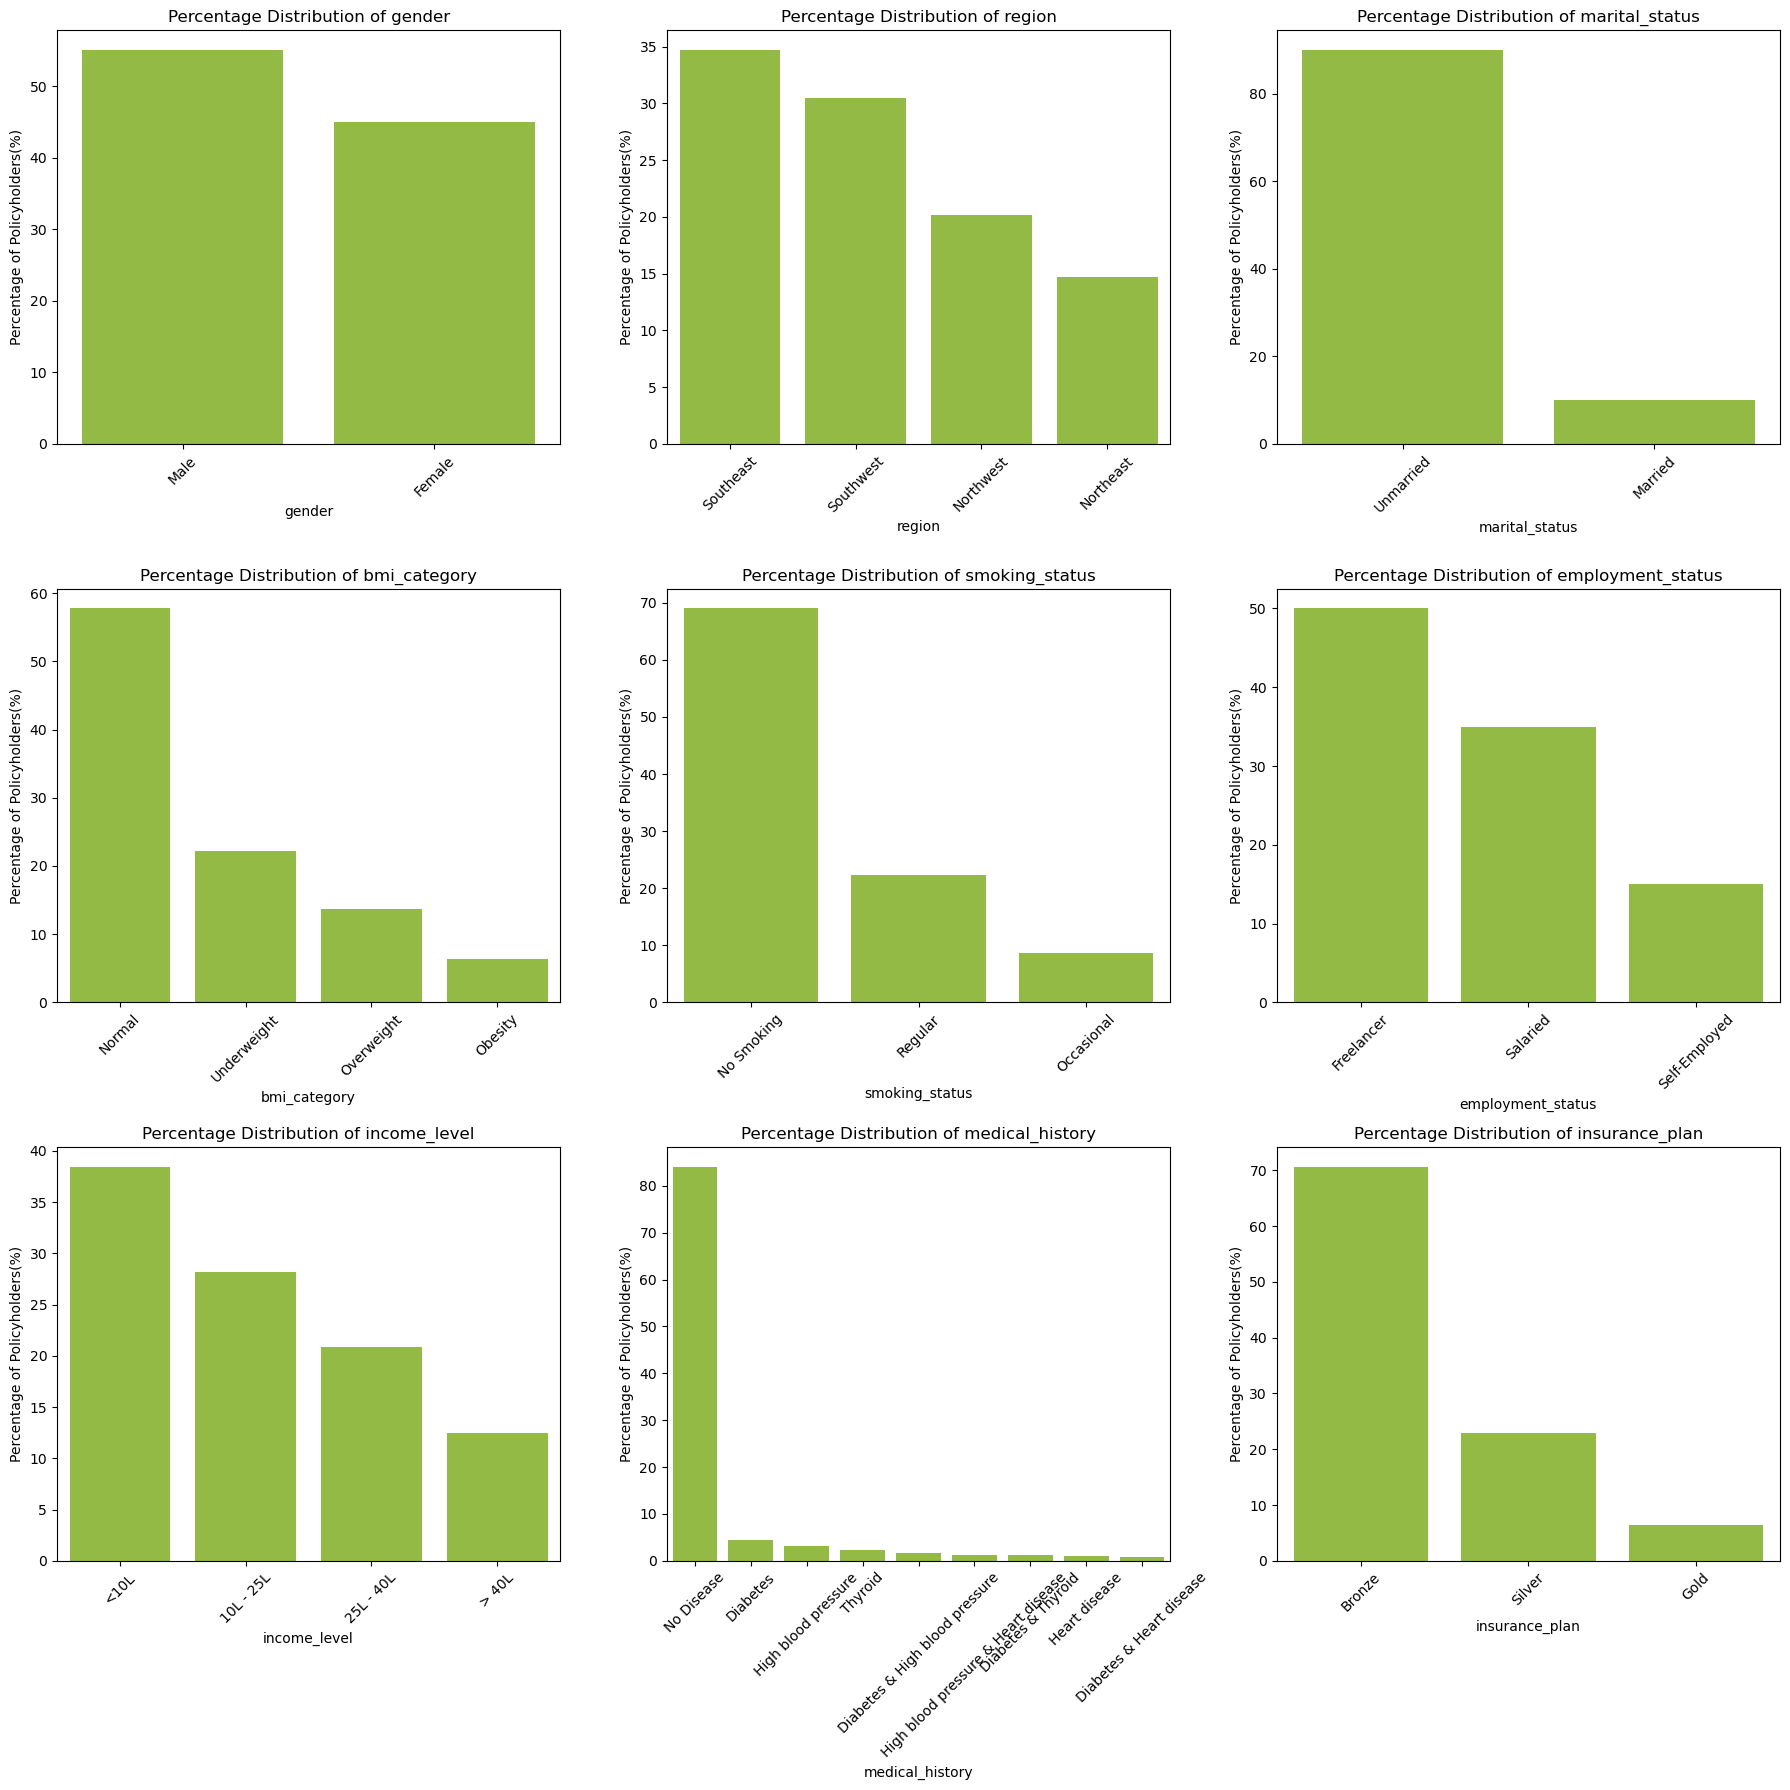

In [33]:
# Plotting pencentage of policy holders w.r.t different categories
fig, axes = plt.subplots(3, 3, figsize=(18,18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True)*100  # normalize =True gives the relation

    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax, color='yellowgreen')
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders(%)')
    ax.set_label(column)     # Set xlabel to the column name for clarity

    # Rotate labels for better readability
    ax.tick_params(axis='x', rotation=45)
    
plt.tight_layout()   # Adjusts plot parameters for better fit in the figure window
plt.show()

The dataset shows an almost balanced distribution between males and females, with females slightly more represented.

Most individuals come from the southeastern and southwestern regions, while the northeastern and northwestern regions have fewer participants.

A large majority of the population is unmarried, indicating a skew toward single individuals in this dataset.

The “Normal” BMI range has the highest proportion, followed by overweight and underweight groups; obesity is the least represented.

Most individuals do not smoke. Former smokers represent a moderate segment, and occasional smokers make up a very small percentage.

The majority is employed, with a notable proportion being self-employed. Unemployment is relatively low.

Lower-income individuals (earning < 25L) constitute the largest share, while those earning above $100L form the smallest group.

Nearly all individuals have no significant medical history; chronic conditions like diabetes, hypertension, and heart issues appear at very low frequencies.

The basic insurance plan is the most commonly held, followed by the silver plan, while the gold plan has the fewest subscribers.

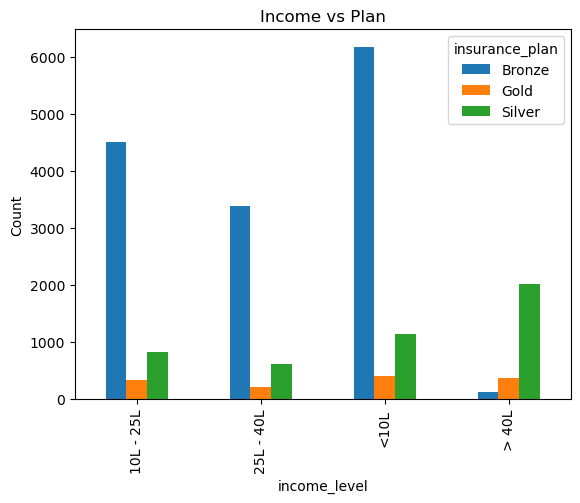

In [34]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
crosstab
crosstab.plot(kind='bar')
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

The chart shows how insurance plan choices vary by income level. 
Bronze plans dominate in lower income groups, while Silver plans become more common as income increases. 
Gold plans remain the least selected across all income levels.

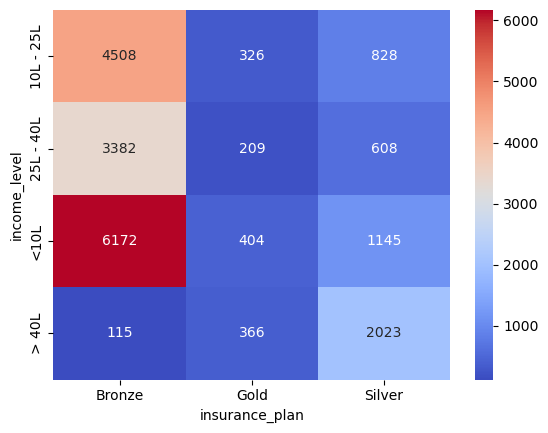

In [35]:
sns.heatmap(crosstab, annot=True, fmt='d', cmap='coolwarm')
plt.show()

This heatmap shows how many people from each income group chose each insurance plan. Lower-income groups overwhelmingly picked the Bronze plan, while higher-income groups were more likely to choose Silver or Gold. The color intensity reflects the magnitude of enrollments in each category.

In [36]:
# checking the data
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [37]:
#  Getting the different categories of medical history
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [38]:
# Adding the risk score  for differenct medical category
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}

# Split medical_history into two columns
df2[['disease1', 'disease2']] = (
    df2['medical_history']
    .str.lower()               # convert entire string to lowercase
    .str.split("&", expand=True)
)

# Replace missing diseases with 'none'
df2['disease1'] = df2['disease1'].fillna('none').str.strip()
df2['disease2'] = df2['disease2'].fillna('none').str.strip()

df2.head()


,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,none
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,no disease,none
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,no disease,none


In [39]:
# Fill missing disease values
df2['disease1'] = df2['disease1'].fillna('none')
df2['disease2'] = df2['disease2'].fillna('none')

# Initialize total score
df2['total_risk_score'] = 0

# Add scores for each disease
for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += (
        df2[disease].map(risk_scores).fillna(0)
    )

# Normalize the risk score
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()

if max_score != min_score:
    df2['normalized_risk_score'] = (
        (df2['total_risk_score'] - min_score) /
        (max_score - min_score)
    )
else:
    df2['normalized_risk_score'] = 0   # All scores identical → normalized = 0

df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,no disease,none,0,0.000000


In [40]:
df2.insurance_plan.unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [41]:
# Mapping the Insurance Plan
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze':1, 'Silver':2, 'Gold':3})
df2.insurance_plan.unique()

array([2, 1, 3])

In [42]:
# Mapping the Income Level
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L':2, '25L - 40L':3, '> 40L':4})
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,4,97,No Disease,2,11857,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,2,15,No Disease,1,5684,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,2,14,No Disease,1,5712,no disease,none,0,0.000000


In [43]:
# Getting dummies for nominal value columns
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status','employment_status']
df3 = pd.get_dummies(df2, columns = nominal_cols, drop_first =True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,no disease,none,0,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,no disease,none,0,...,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,No Disease,1,5684,no disease,none,0,...,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,No Disease,1,5712,no disease,none,0,...,1,0,1,0,1,0,0,0,0,0


In [44]:
# Dropping the columns
df4 = df3.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,1,5684,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,1,5712,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


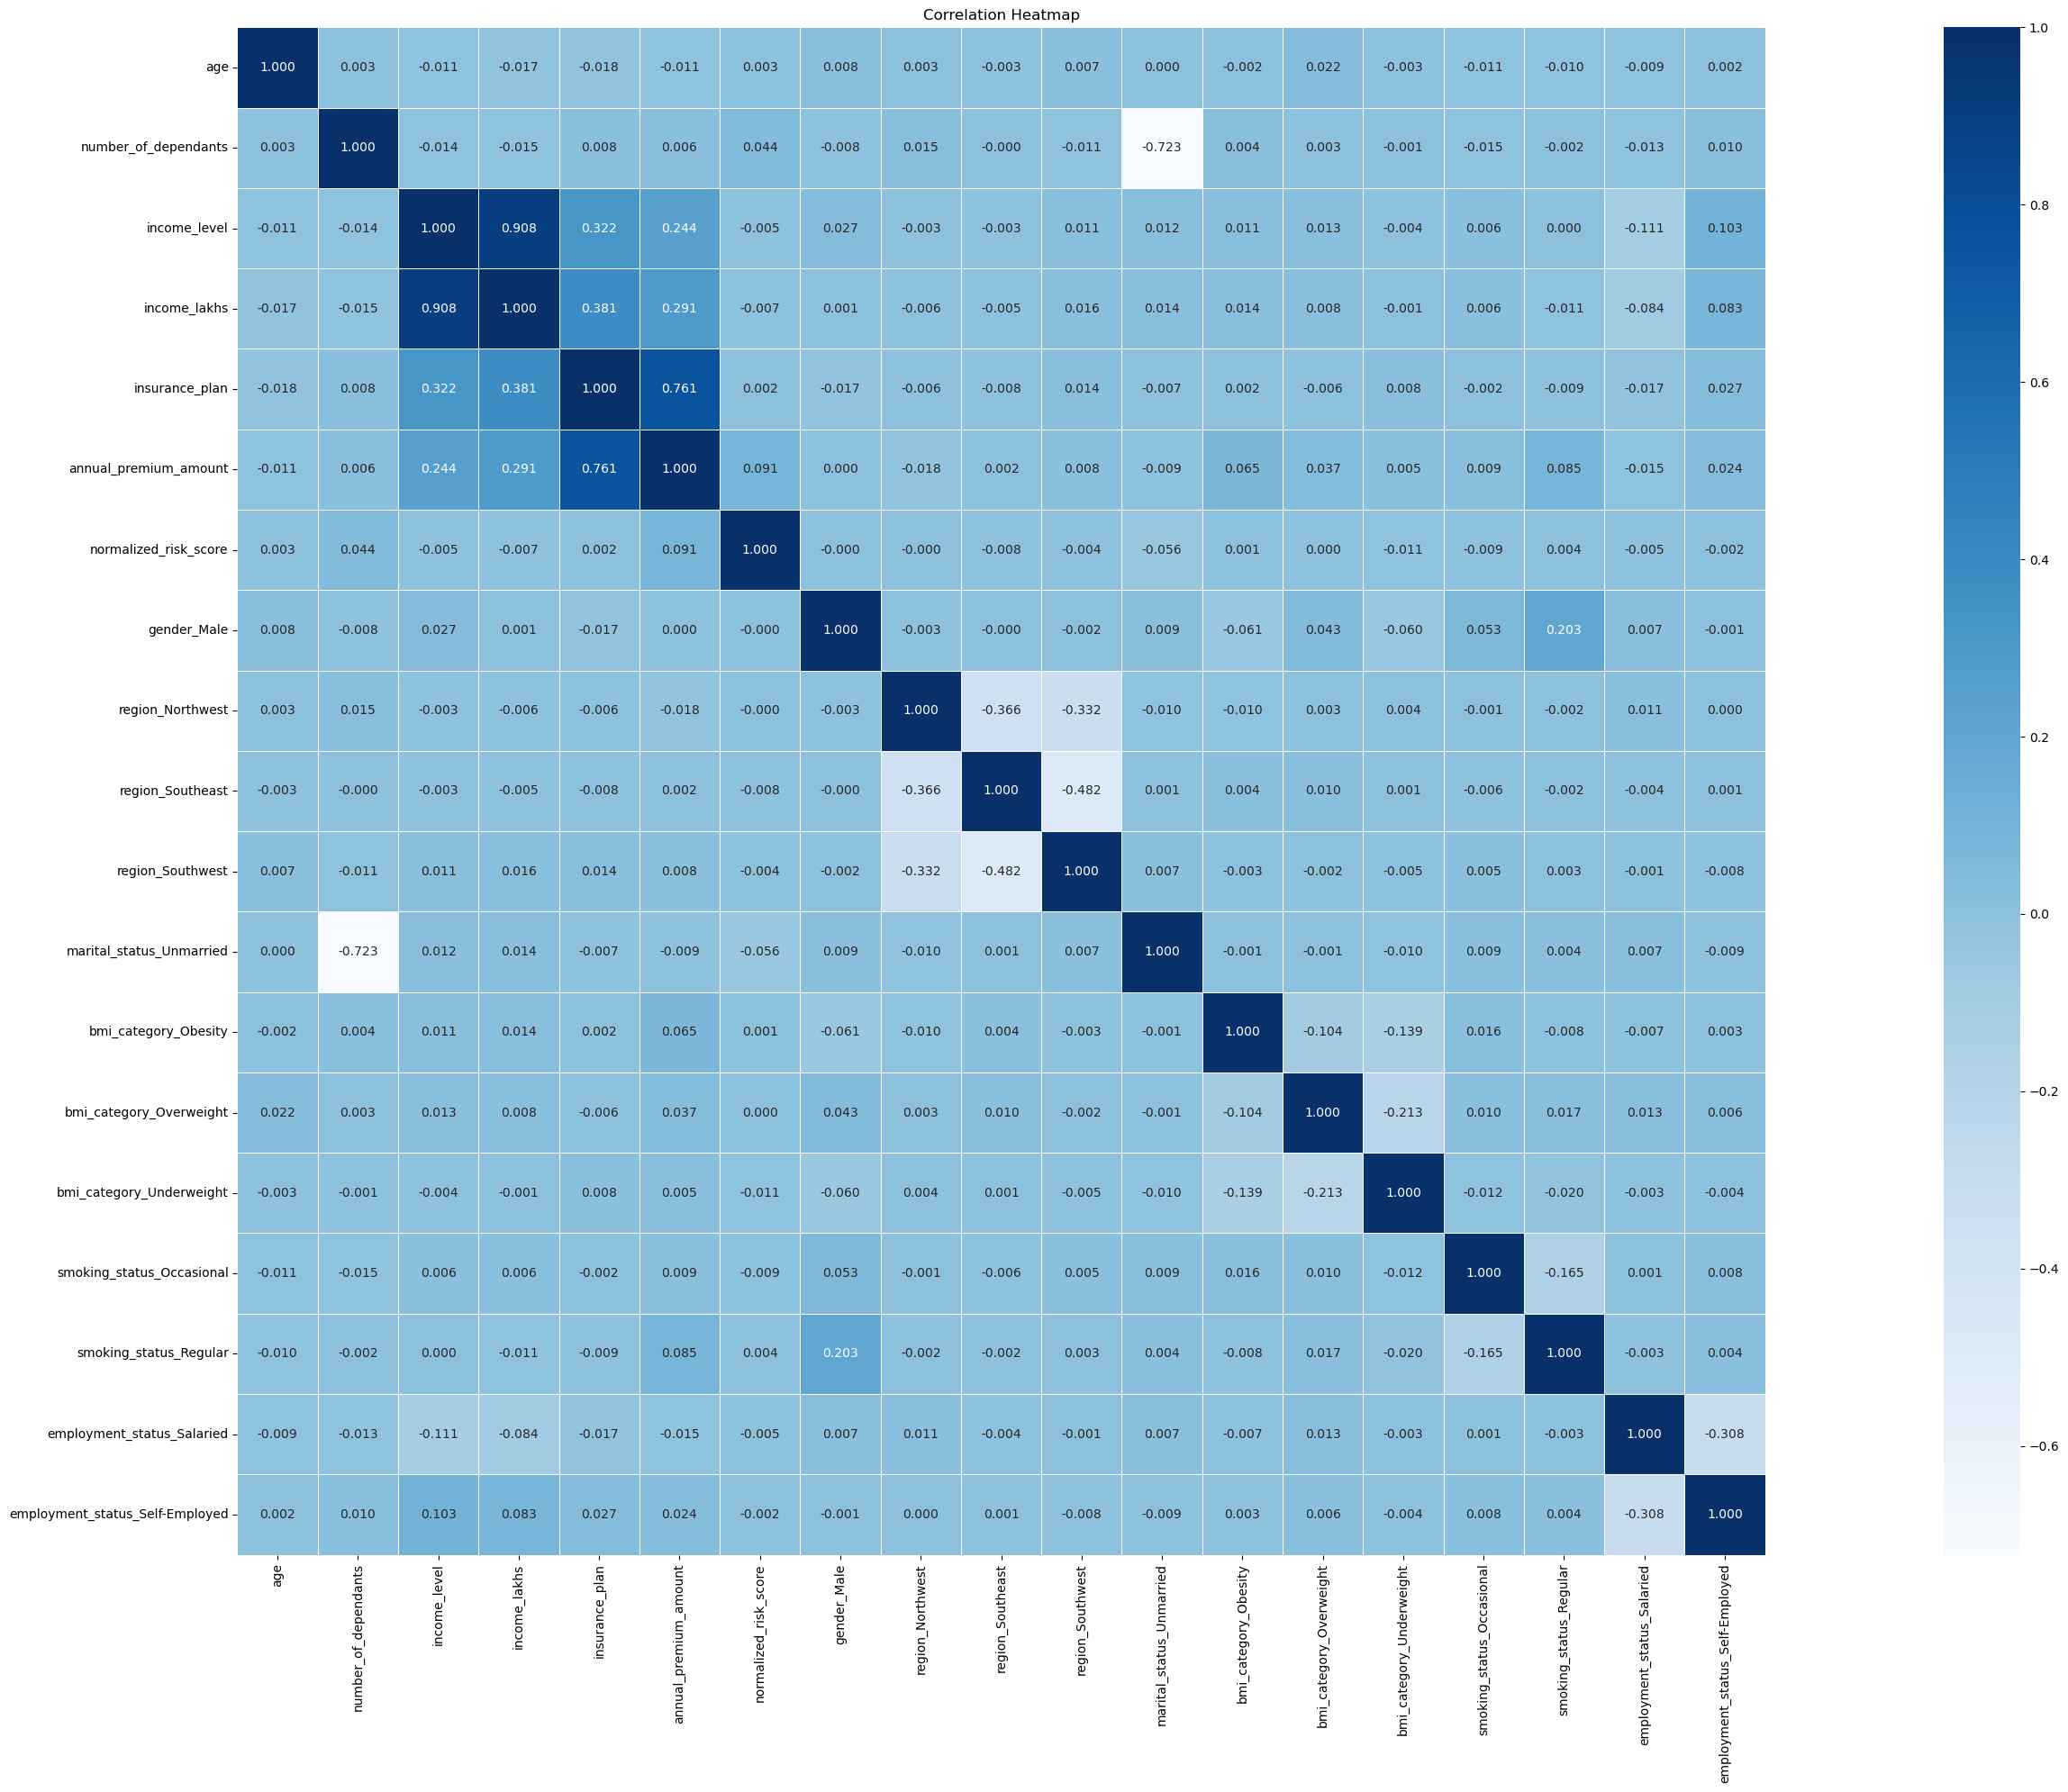

In [45]:
# Select only numeric columns for correlation
corr_matrix = df4.corr()

# Set up the matplotlib figure
plt.figure(figsize=(40, 20))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".3f", linewidths=0.5, square=True)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

This is a correlation heatmap showing how strongly each feature is linearly related to others. Most correlations are close to zero, meaning the variables are largely independent. The only strong correlations occur between one-hot encoded categorical variables, which is expected since they come from the same original category. There are no indications of harmful multicollinearity among the main numerical features.

In [46]:
# Scaling the necessary columns 
X = df4.drop('annual_premium_amount', axis='columns')
y= df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age', 'number_of_dependants','income_level', 'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,1.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,1.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.333333,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.333333,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


In [47]:
# Getting more information
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
# Calculate the Vif score
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column']= data.columns
    vif_df['VIF']= [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [49]:
calculate_vif(X)

,Column,VIF
0,age,3.142881
1,number_of_dependants,1.860761
2,income_level,11.928707
3,income_lakhs,11.874242
4,insurance_plan,1.592892
5,normalized_risk_score,1.154223
6,gender_Male,2.310023
7,region_Northwest,2.147701
8,region_Southeast,2.970188
9,region_Southwest,2.730503


The VIF table checks multicollinearity among your model’s features. Most variables have acceptable VIF values (below 5), indicating low to moderate correlation. However, income_level and income_lakhs have very high VIF (>10), showing severe multicollinearity.

In [50]:
# Dropping the income_level
calculate_vif(X.drop('income_level', axis ='columns'))

,Column,VIF
0,age,3.141534
1,number_of_dependants,1.858110
2,income_lakhs,2.291873
3,insurance_plan,1.587794
4,normalized_risk_score,1.154174
5,gender_Male,2.299848
6,region_Northwest,2.146767
7,region_Southeast,2.968993
8,region_Southwest,2.729813
9,marital_status_Unmarried,7.299818


On dropping the income level, the VIF values are within acceptable limit.

In [51]:
# dropping the income level
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


## Model Training

In [52]:
# importing the necessary training library
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', X_train.shape)
print('y_test:', y_test.shape)

X_train: (14060, 17)
X_test: (6026, 17)
y_train: (14060, 17)
y_test: (6026,)


### Using Linear Regression

In [53]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score, test_score

(0.6020471274164894, 0.6047589163893645)

In [54]:
# making the prediction
y_preds = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_preds)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE:", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE: 3005669.8791236714 RMSE:  1733.6867880686152


In [55]:
# model coefficients
model_lr.coef_

array([ 5.51905147e+01, -1.45039643e+02, -3.60667677e+01,  7.00007042e+03,
        1.11127879e+03,  9.82564766e+00, -1.14273450e+02, -3.64663714e+01,
       -6.72232248e+01, -5.85343424e+01,  7.92952660e+02,  4.35760406e+02,
        1.69728916e+02,  2.44813937e+02,  6.19082947e+02, -1.30535485e+01,
       -4.34272200e+00])

In [56]:
# X_test columns
X_test.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [57]:
# creating a dataframe for coefficient
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df

,Coefficients
age,55.190515
number_of_dependants,-145.039643
income_lakhs,-36.066768
insurance_plan,7000.070416
normalized_risk_score,1111.278786
gender_Male,9.825648
region_Northwest,-114.273450
region_Southeast,-36.466371
region_Southwest,-67.223225
marital_status_Unmarried,-58.534342


In [58]:
# sorting the feature importance
coef_df = coef_df.sort_values(by = 'Coefficients', ascending=True)
coef_df

,Coefficients
number_of_dependants,-145.039643
region_Northwest,-114.273450
region_Southwest,-67.223225
marital_status_Unmarried,-58.534342
region_Southeast,-36.466371
income_lakhs,-36.066768
employment_status_Salaried,-13.053549
employment_status_Self-Employed,-4.342722
gender_Male,9.825648
age,55.190515


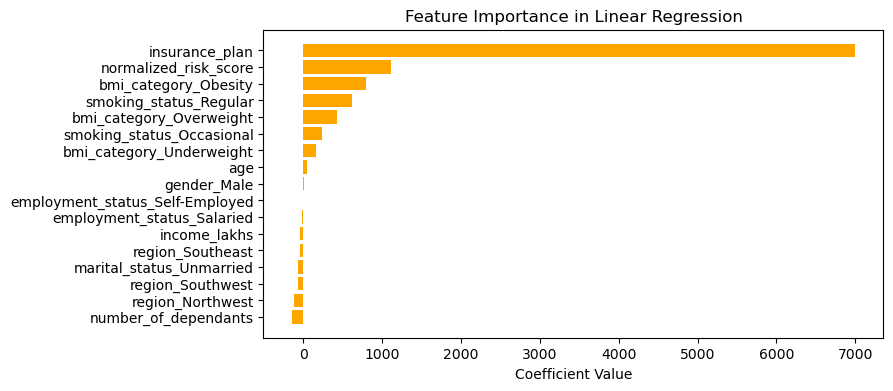

In [59]:
# Plotting the feature importance
plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='orange')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

This bar chart shows the coefficients of a linear regression model, indicating how strongly each feature influences the predicted outcome. Insurance plan has by far the largest impact, followed by normalized risk score and certain BMI and smoking status categories. Features near zero contribute very little to the model. Positive coefficients indicate features that increase the predicted value.


### Using Ridge Regression

In [61]:
model_rg = Ridge()
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score, test_score

(0.6020466631305188, 0.6047715291063815)

### using XGBoost Regression

In [63]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.7251046895980835, 0.5638787746429443)

In [64]:
# making prediction
y_preds = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_preds)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost Regression ==> MSE:", mse_xgb, "RMSE: ", rmse_xgb)

XGBoost Regression ==> MSE: 3316548.97851731 RMSE:  1821.1394725603282


## Randomized SearchCV

In [65]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42)
random_search.fit(X_train, y_train)
random_search.best_score_

0.5997088948885599

In [66]:
# finding best pararms
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

In [67]:
# best model
best_model = random_search.best_estimator_

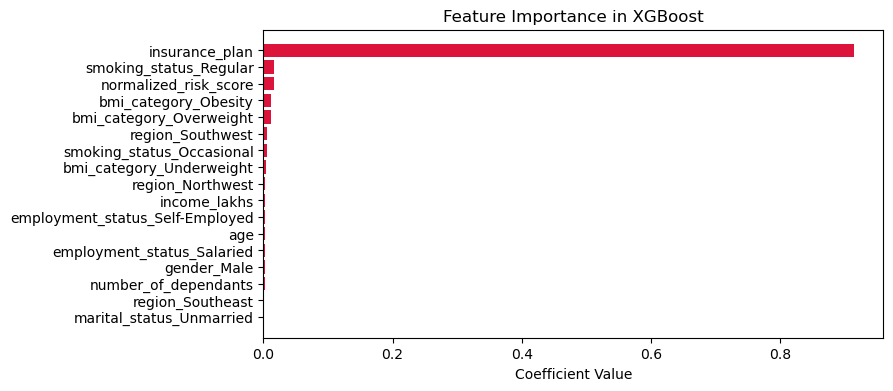

In [68]:
# Plotting the feature importance
feature_importances = best_model.feature_importances_
coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by= 'Coefficients', ascending=True)

plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='crimson')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

### Error Analysis

In [69]:
# conducting error analysis
y_preds = best_model.predict(X_test)

residuals = y_preds - y_test
residuals_pct = residuals*100/ y_test

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_preds,
    'diff' : residuals,
    'diff_pct': residuals_pct

})
results_df.head()

,actual,predicted,diff,diff_pct
12774,6238,6669.329590,431.329590,6.914549
14758,9462,6999.429199,-2462.570801,-26.025902
13205,5152,6998.085449,1846.085449,35.832404
14278,6988,7868.310059,880.310059,12.597454
19351,4917,6677.658203,1760.658203,35.807570


<Axes: xlabel='diff_pct', ylabel='Count'>

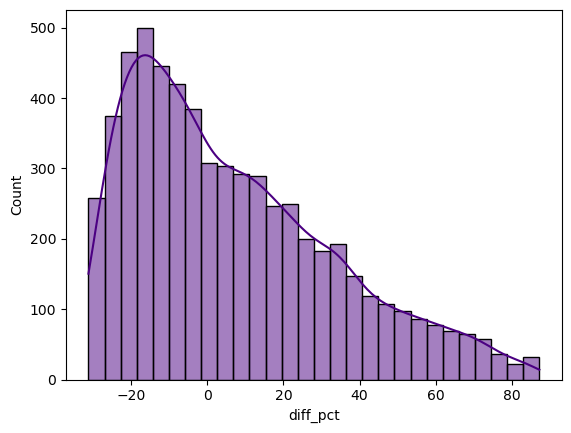

In [70]:
sns.histplot(results_df['diff_pct'], kde=True, color='indigo')

This histogram shows the distribution of `diff_pct` values, with a kernel density estimate (KDE) overlaid to smooth the shape of the distribution. The data are skewed to the right: many values cluster between about –20% and 20%, while fewer extend into high positive percentages. The KDE curve highlights a strong peak around slightly negative values and a long tail toward larger positive differences.

In [71]:
# Finding the rows where diff_pct greater than extreme error threshold
extreme_error_threshold = 10

extreme_results_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df.shape

(4407, 4)

In [72]:
# Finding extreme_errors_pct
extreme_errors_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_errors_pct

73.13308994357783

So, there are 73% extreme errors

In [73]:
# Finding the rows where Difference_pct > 50 percentage
results_df[np.abs(results_df.diff_pct)>50]

,actual,predicted,diff,diff_pct
14882,4740,7150.404297,2410.404297,50.852411
12669,3985,7001.023926,3016.023926,75.684415
1601,5316,7974.411621,2658.411621,50.007743
6908,4264,6585.947754,2321.947754,54.454685
15568,4623,7407.637695,2784.637695,60.234430
...,...,...,...,...
5125,4568,6968.547363,2400.547363,52.551387
5179,5036,7792.064453,2756.064453,54.727253
1534,3717,6734.904785,3017.904785,81.191950
5730,4354,7042.687988,2688.687988,61.752136


In [74]:
# Sorting the diff_pct values
results_df[np.abs(results_df.diff_pct)>50].sort_values('diff_pct', ascending=False)

,actual,predicted,diff,diff_pct
4169,3517,6584.604004,3067.604004,87.222178
4692,3516,6572.262207,3056.262207,86.924409
12285,3532,6585.947754,3053.947754,86.465112
3652,3536,6585.947754,3049.947754,86.254179
16580,3538,6585.947754,3047.947754,86.148891
...,...,...,...,...
405,4659,6999.680176,2340.680176,50.239969
3032,4388,6585.947754,2197.947754,50.089967
44,4389,6584.604004,2195.604004,50.025154
15383,4390,6585.947754,2195.947754,50.021589


In [75]:
# Getting the index value
X_test.index

Index([12774, 14758, 13205, 14278, 19351, 10622, 16391, 14799, 17184, 16348,
       ...
        8695,  9658, 14195,  1365,   399, 17652,  5807, 10298, 13316,  2583],
      dtype='int64', length=6026)

In [76]:
# finding extreme results index
extreme_results_df.index

Index([14758, 13205, 14278, 19351, 10622, 14799, 16348,  5573,  5634, 14882,
       ...
        5484,  8988,  8695,  9658,  1365,   399, 17652,  5807, 10298, 13316],
      dtype='int64', length=4407)

In [77]:
# extreme errors data
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14758,0.285714,0.000000,0.060606,0.0,0.000000,0,0,0,1,1,0,0,0,0,1,0,1
13205,0.714286,0.333333,0.141414,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,1
14278,0.714286,0.333333,0.222222,0.0,0.000000,1,0,1,0,1,1,0,0,0,1,0,0
19351,0.571429,0.000000,0.101010,0.0,0.000000,1,0,0,1,1,0,0,1,0,0,0,0
10622,0.428571,0.333333,0.050505,0.0,0.357143,0,0,1,0,1,0,1,0,0,0,0,0


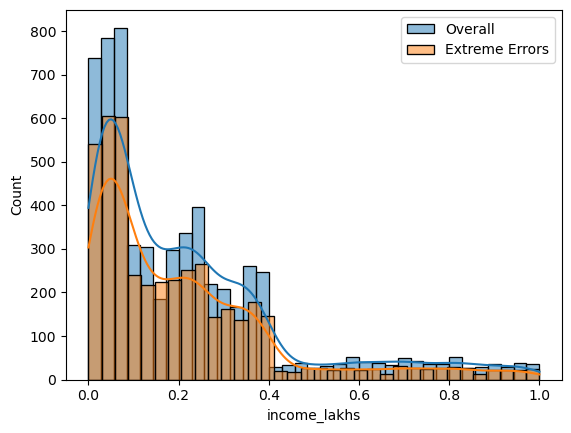

In [78]:
sns.histplot(X_test.income_lakhs, label = "Overall", kde=True)
sns.histplot(extreme_errors_df.income_lakhs, label = "Extreme Errors", kde=True)
plt.legend()
plt.show()

This plot compares the income distribution of the full dataset (blue) with the subset of cases that produced extreme model errors (orange).
Both distributions are heavily skewed toward lower incomes, but the extreme-error cases are somewhat more concentrated in the mid-income range.
At higher incomes, both groups thin out, though extreme-error cases remain relatively more frequent.


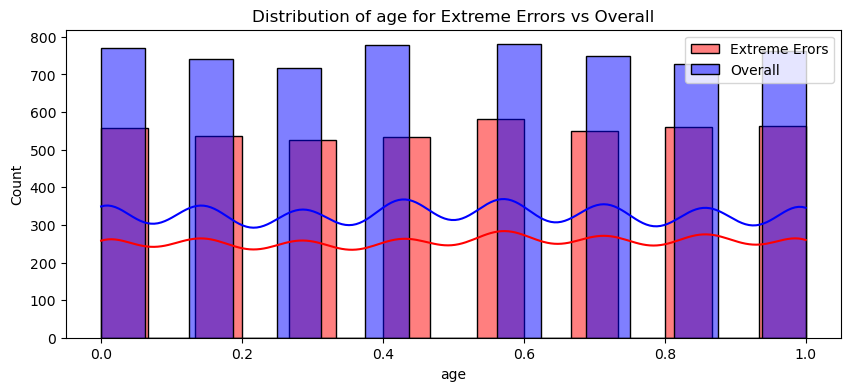

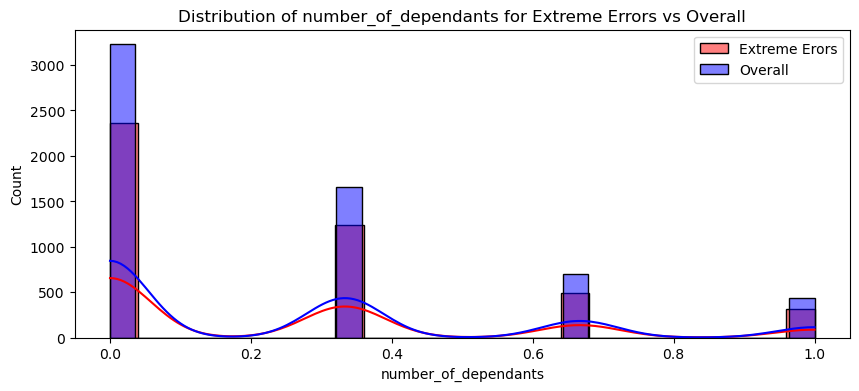

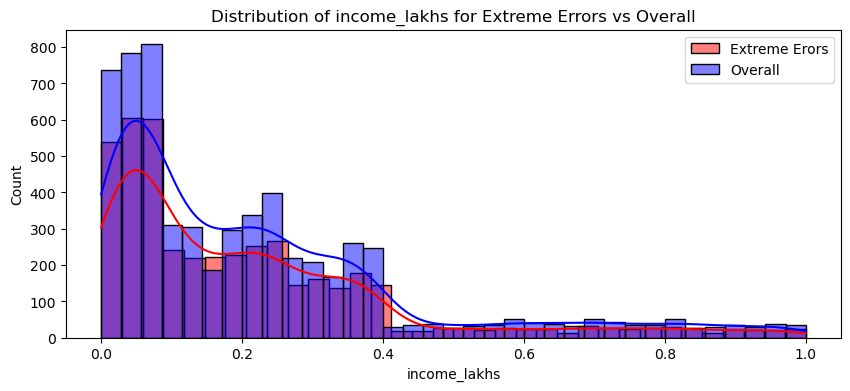

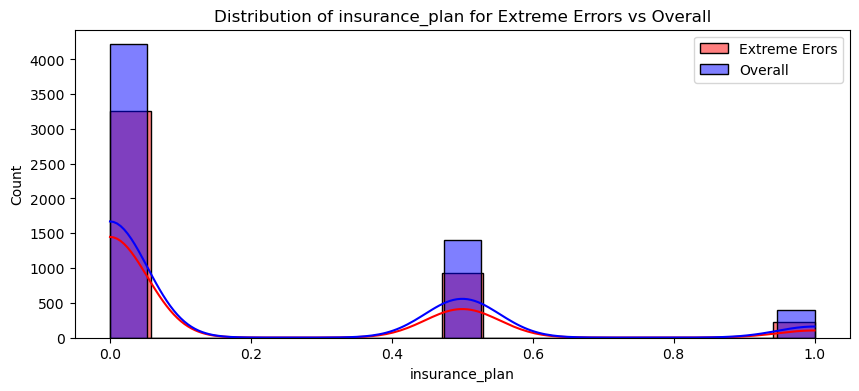

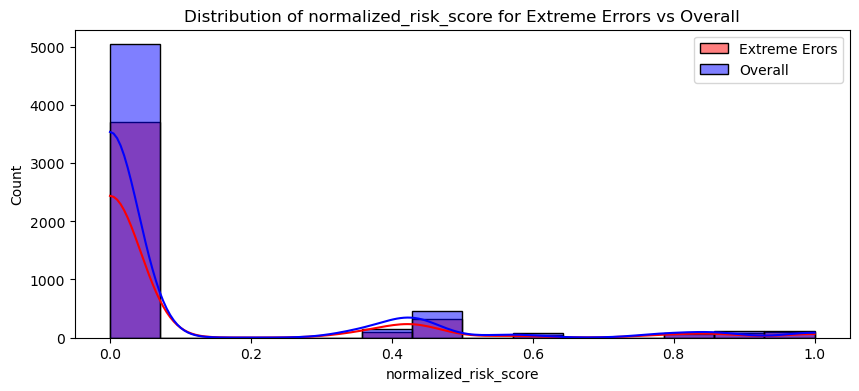

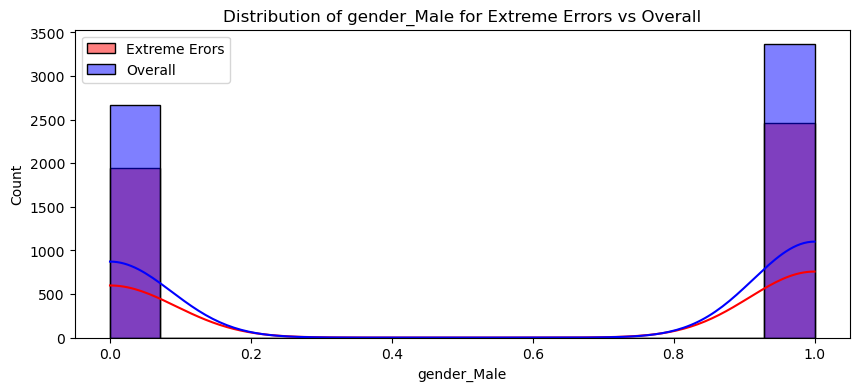

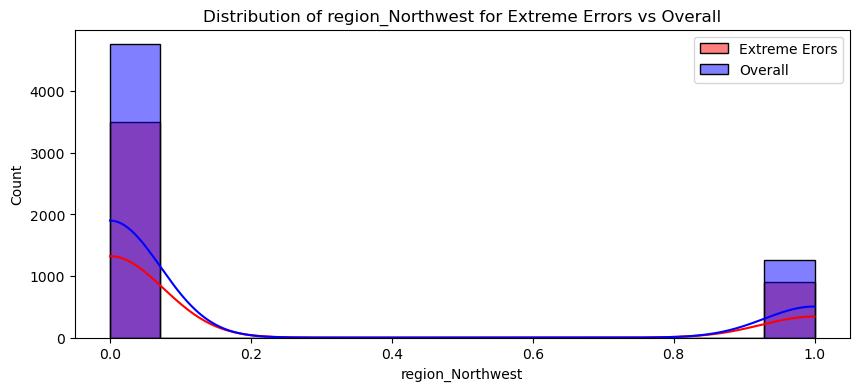

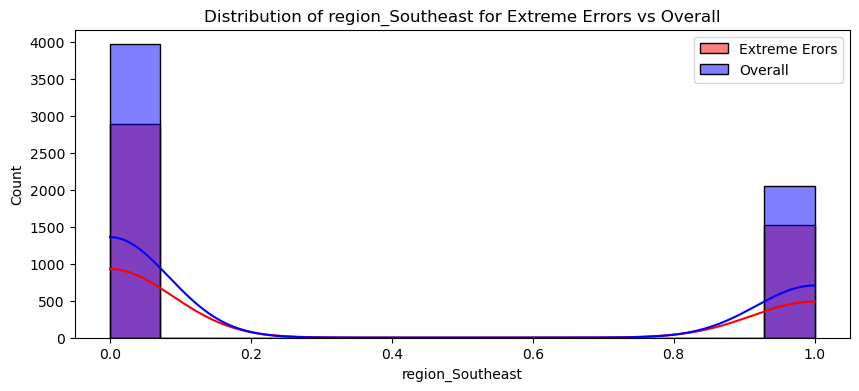

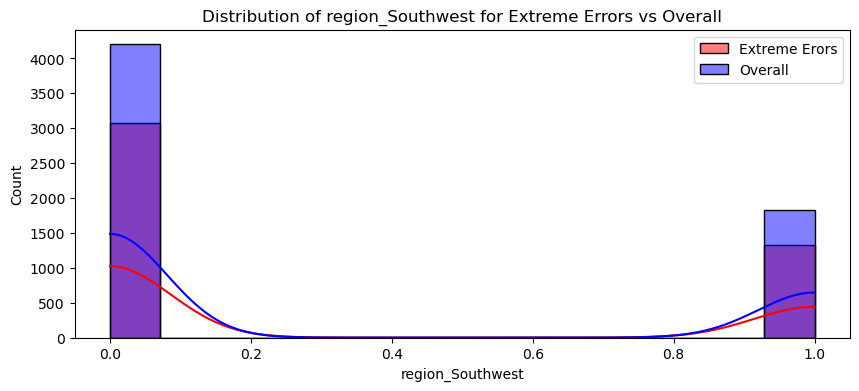

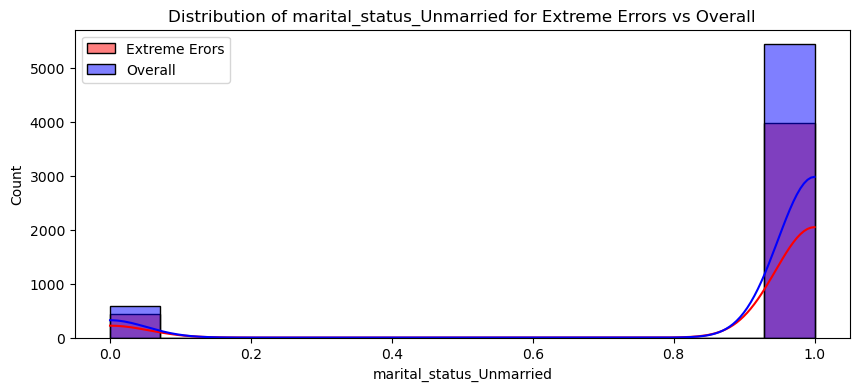

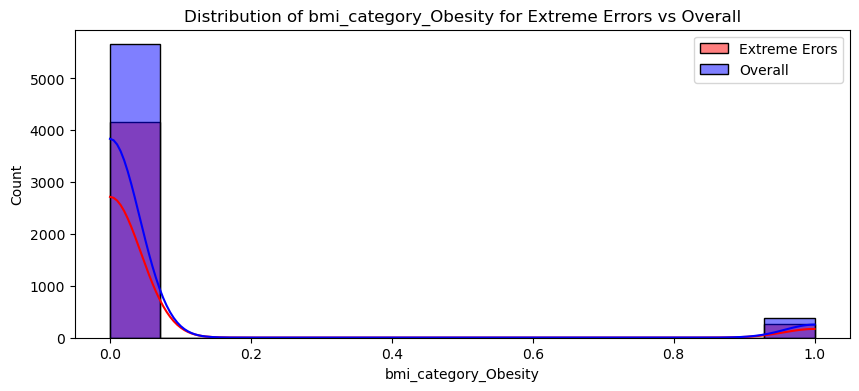

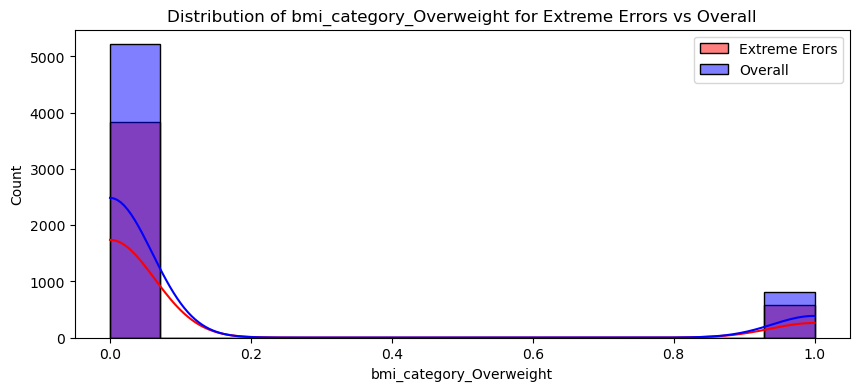

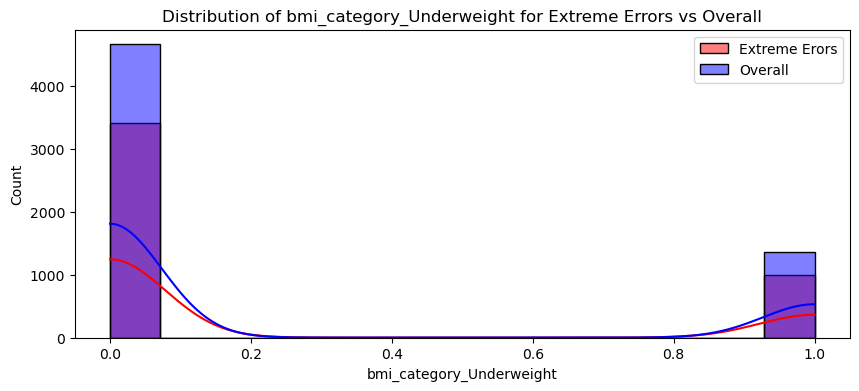

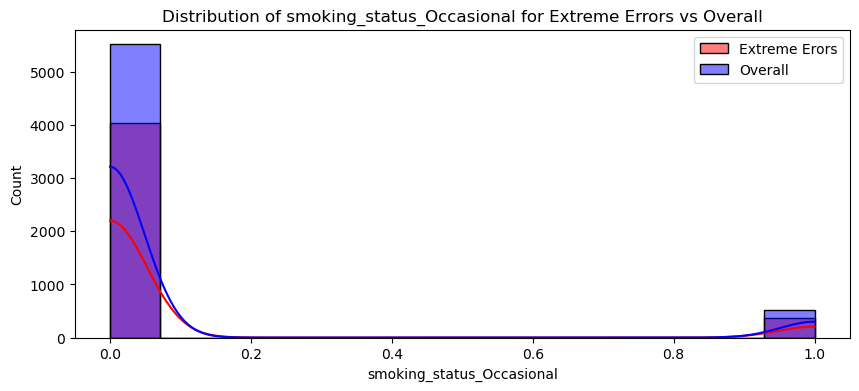

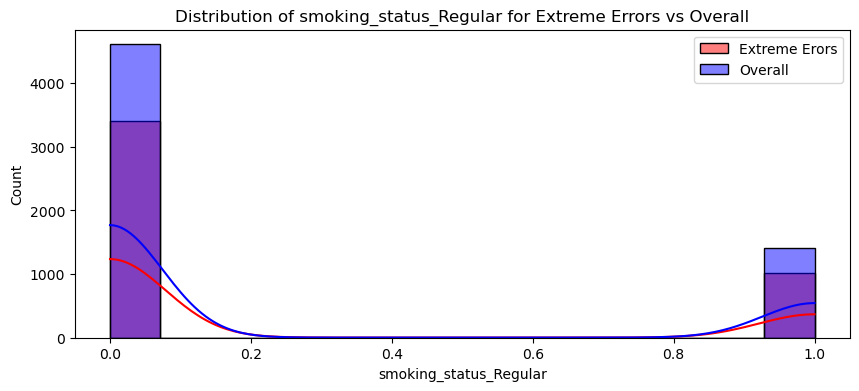

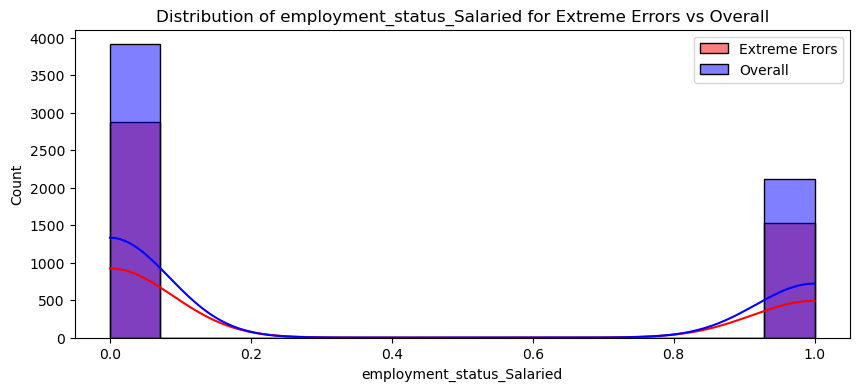

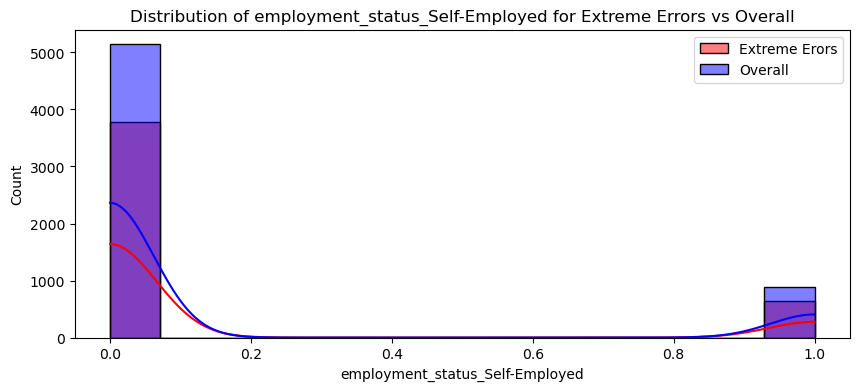

In [79]:
# Plot of extreme errors and overall errors as per different column values
for feature in X_test.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(extreme_errors_df[feature], color='red', label ='Extreme Erors', kde= True)
    sns.histplot(X_test[feature], color='blue', label ='Overall', alpha =0.5, kde= True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

Errors are spread across all categories

## Summary

The results of this analysis indicate that predicting healthcare insurance premiums for individuals aged 25 and below is significantly more challenging than for older age groups. The evaluated models demonstrate weak predictive performance, suggesting that the current feature set does not adequately capture the factors driving premium variation in the younger population.

It is clear that our current models are underperforming, as indicated by the low evaluation scores. The models are not effectively leveraging the available features to predict the target variable. To improve performance, we can explore generating and adding new features to the existing premium_young dataset.

Future improvements may include more granular health indicators, behavioral risk factors, interaction features, or alternative modeling approaches better suited for low-variance targets. Overall, this analysis highlights the importance of age-based segmentation and targeted feature engineering when developing predictive models for healthcare insurance pricing.